In [42]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [43]:
# Step 1: Load digits012.mat data and split between x/y.
digits = loadmat('/content/digits012.mat')
X = digits['x']
y = digits['y'][0,:]

In [44]:
# Step 2: Split the data into train and test sets using a 70-30 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit an SVM classifier
y_train[np.where(y_train == '0')[0]] = 0
y_train[np.where(y_train == '1')[0]] = 1
y_train[np.where(y_train == '2')[0]] = 2

y_test[np.where(y_test == '0')[0]] = 0
y_test[np.where(y_test == '1')[0]] = 1
y_test[np.where(y_test == '2')[0]] = 2

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [45]:
# Step 3: Perform PCA analysis and take out the best number of components that will specify ~95%
# of information from original dataset features.
var_thr = 0.95
pca = PCA(n_components=784).fit(X_train)
pca_cumsum = np.cumsum(pca.explained_variance_ratio_)

var_comp = np.where(pca_cumsum >= var_thr)[0]
var_comp = var_comp[0]
print('No. of required components for explaining {}% variance: {}'.format(int(var_thr*100),var_comp))

No. of required components for explaining 95% variance: 125


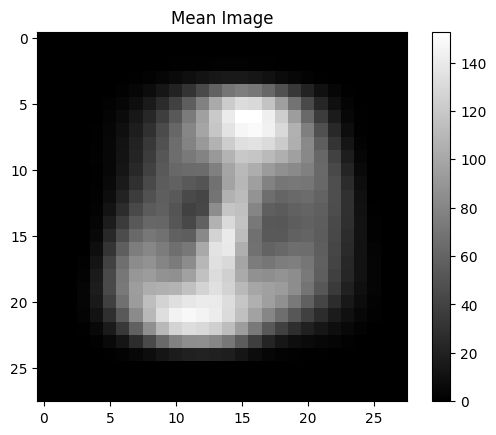

In [46]:
# Step 4: Plot the Mean Image
mean_image = pca.mean_.reshape(28, 28)
plt.imshow(mean_image, cmap='gray')
plt.title("Mean Image")
plt.colorbar()
plt.show()

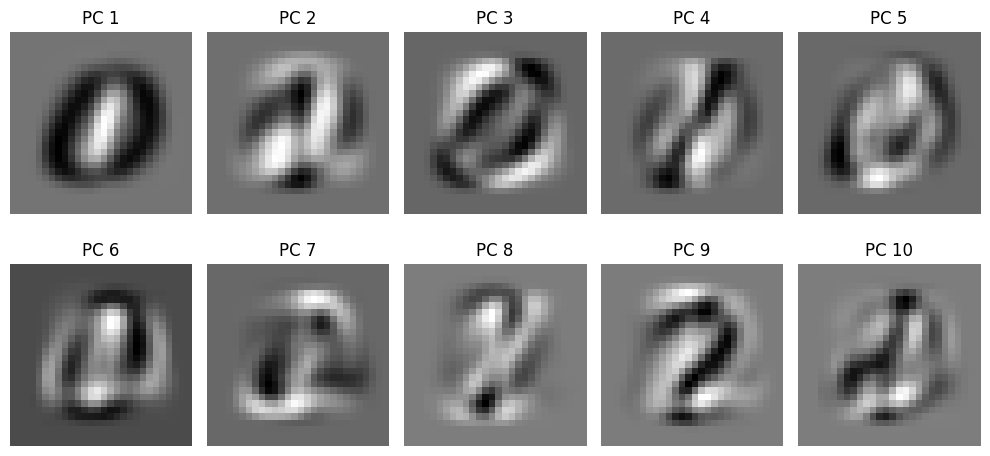

In [47]:
# Step 5: Plot First 10 Principal Components
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    component = pca.components_[i].reshape(28, 28)
    ax.imshow(component, cmap='gray')
    ax.set_title(f"PC {i+1}")
    ax.axis('off')
plt.tight_layout()
plt.show()

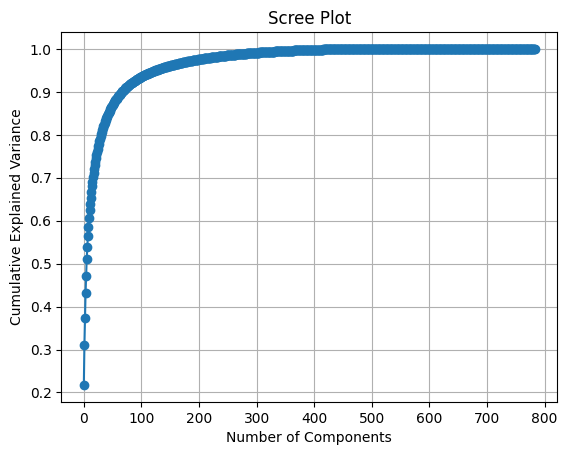

Explained Variance Ratio: [2.17514496e-01 9.21426246e-02 6.42716363e-02 5.67331234e-02
 4.15734560e-02 3.86336066e-02 2.85137500e-02 2.48212183e-02
 2.21539401e-02 1.99043052e-02 1.80201236e-02 1.47820833e-02
 1.47345147e-02 1.32254364e-02 1.26767578e-02 1.13378686e-02
 1.06021142e-02 9.85061213e-03 9.26799187e-03 8.52017665e-03
 8.20551945e-03 7.75528358e-03 7.46124753e-03 6.90451287e-03
 6.85472158e-03 6.53441701e-03 6.37941739e-03 5.77081646e-03
 5.55700341e-03 5.34729307e-03 5.13457053e-03 4.99240894e-03
 4.63826651e-03 4.55376598e-03 4.34154520e-03 3.93304153e-03
 3.86386641e-03 3.69116422e-03 3.45695070e-03 3.37977523e-03
 3.26581084e-03 3.08209483e-03 3.03508295e-03 3.02781826e-03
 2.97075430e-03 2.86604831e-03 2.81317907e-03 2.72995352e-03
 2.63797247e-03 2.50139094e-03 2.44080419e-03 2.37345958e-03
 2.23588009e-03 2.20625910e-03 2.15348145e-03 2.10400548e-03
 2.04127974e-03 1.93161675e-03 1.88084368e-03 1.81988283e-03
 1.79424636e-03 1.77497273e-03 1.66753435e-03 1.60113694e-0

In [48]:
# Step 6: Scree Plot
plt.plot(pca_cumsum, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Scree Plot")
plt.grid()
plt.show()

# Print the explained variance ratio for each principal component
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

In [49]:
# Step 7: Transform the train and test data into the component basis vector to get the new linear
# combination features.

# Apply PCA transformation to the train and test datasets
x_train_pca = pca.transform(X_train)
x_test_pca = pca.transform(X_test)

# Select only the required components
x_train_pca = x_train_pca[:,:var_comp]
x_test_pca = x_test_pca[:,:var_comp]

In [50]:
# Step 8: Train SVM Classifier with RBF Kernel
svm = SVC(kernel='rbf')
svm.fit(x_train_pca, y_train)

SVC()

In [ ]:
# Step 9: Predict and Evaluate
y_pred = svm.predict(x_test_pca)
print("Classification Report (SVM):")
print(classification_report(y_test, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for SVM")
plt.show()

In [ ]:
# Step 10: Pipeline (PCA + SVM) with custom PCAVarianceTreshold class to capture the components required.
class  PCAVarianceThreshold(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.95):
        self.threshold = threshold

    def fit(self, X, y=None):
        # Fit PCA to determine the number of components
        self.pca_ = PCA(n_components=min(X.shape))
        self.pca_.fit(X)

        # Calculate the cumulative variance and select the number of components for the threshold
        cumsum = np.cumsum(self.pca_.explained_variance_ratio_)
        self.n_components_ = np.where(cumsum >= self.threshold)[0][0]

        return self

    def transform(self, X):
        # Use the selected number of components to transform the data
        return self.pca_.transform(X)[:, :self.n_components_]

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

pipeline = Pipeline([
    ('pca', PCAVarianceThreshold(var_thr)),  # PCA first
    ('svm', SVC(kernel='rbf'))  # Then SVM
])
pipeline.fit(X_train, y_train)

# Predict using pipeline (automatically applies PCA)
y_pred_pipe = pipeline.predict(X_test)

# Final Classification Report
print("Classification Report (Pipeline SVM):")
print(classification_report(y_test, y_pred_pipe))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred_pipe)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Pipeline SVM")
plt.show()